# **Titanik: Machine Learning from Disaster**

Name: Neta Ben Mordechai  
Name: Itay Chabra

Link to Kaggle: https://www.kaggle.com/netabenmordechai 

---

## **Overview**  
This assignment focuses on building a predictive model to determine the survival of passengers on the Titanic using logistic regression techniques based on various features such as age, class, and fare. The project involves preprocessing the data (handling missing values and encoding categorical variables), performing exploratory data analysis (EDA), and applying machine learning techniques. The model's performance is evaluated using KFold cross-validation, and metrics like accuracy, precision, recall, F1 score, and log loss are calculated. Finally, the model is tested on a separate test set, and the results are saved for submission.  
The goal is to build a reliable and accurate predictive model for the Titanic passenger's survival.

---

### Imports

In [413]:
# import numpy, matplotlib, etc.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, log_loss

## Data Investigation and Preprocessing  

---

Import train and test datasets

In [414]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [415]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [416]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [417]:
print ("Train: ",train.shape[0],"passengers, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"passengers, and ",test.shape[1],"features")

Train:  891 passengers, and  12 features
Test:  418 passengers, and  11 features


### **Explanation of the Features:**
We have 12 columns; 11 features and 1 lable

**Data Dictionary**

| Variable | Definition | Key | Type
| :-: | :-: | :-: | :-:
| Survived | Survival | 0 = No, 1 = Yes | int 
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd | int
| Sex | Sex | | string
| Age | Age in years | | float
| SibSp | # of siblings / spouses aboard the Titanic | | int
| Parch | # of parents / children aboard the Titanic | | int
| Ticket | 	Ticket number | | string
| Fare | Passenger fare | | float
| Cabin | Cabin number | | string
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton | string


*The Target:*

* `Survived` - (0 = No, 1 = Yes)

Our features are devided to 3 types:
*  **categorical** (`Sex`, `Embarked` and the target `Survived`):

Categorical features are features that has no intrinsic order between their values (survived, not-survived).   

* **ordinal** (`SibSp`, `Parch`, `Pclass`):

Ordinal features have order between values (1 child, 2 childs, etc.).

* **Numerical** (`Age`, `Fare`).

Numerical features are features that unlike ordinal features, there is a meaning to the values in between  

---

We can drop the Id colum since it's unnecessary for the prediction process

In [418]:
train_ID = train['PassengerId']
test_ID = test['PassengerId']

train.drop("PassengerId", axis = 1, inplace = True)
test.drop("PassengerId", axis = 1, inplace = True)

## Feature Engineering
* Extract title from `Name` to create a new feature named Title
* Combine `SibSp` and `Parch` to a new feature named FamilyCount

---

In [419]:
def extract_titles(df):
    df['Title'] = df['Name'].str.extract(', ([A-Za-z]+).', expand=False)

def change_to_common_title(df):
    common = ['Master', 'Mr', 'Miss', 'Mrs']
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = [x if x in common else 'Rare' for x in df['Title']]

extract_titles(train)
extract_titles(test)

change_to_common_title(train)
change_to_common_title(test)

In [420]:
def create_family_feature(df):
    df['FamilyCount'] = df['SibSp'] + df['Parch'] + 1

create_family_feature(train)
create_family_feature(test)

- We extracted titles from `Name` and there is no need for this feature anymore
- `SibSp` and `Parch` where combined to the a column `FamilyCount`

In [421]:
train.drop(['Name', 'SibSp', 'Parch'], axis = 1, inplace = True)
test.drop(['Name', 'SibSp', 'Parch'], axis = 1, inplace = True)

In [422]:
print("Train Data:")
train.head()

Train Data:


,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilyCount
0,0,3,male,22.0,A/5 21171,7.2500,NaN,S,Mr,2
1,1,1,female,38.0,PC 17599,71.2833,C85,C,Mrs,2
2,1,3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,1,1,female,35.0,113803,53.1000,C123,S,Mrs,2
4,0,3,male,35.0,373450,8.0500,NaN,S,Mr,1


## Encoding the data  - `Title`, `Sex`

---

### One-Hot Encode Categorical Features
In order to fill in the missing values and also train the machine we need to encode the categorical features in our Dataset.

Our Dataset includes both numeric and catagorical features. To handle this we need to preprocess the dataset to convert the catagorical features into a numeric format. We will use one-hot encoding for this task

we will do this with the get_dummies() function in Panda

In [423]:
# Convert the 'Title' column to string or category type
train['Title'] = train['Title'].astype(str)
test['Title'] = test['Title'].astype(str)

# One-hot encode the 'Title' feature
train_title_dummies = pd.get_dummies(train['Title'], prefix='Title', dtype=int)
test_title_dummies = pd.get_dummies(test['Title'], prefix='Title', dtype=int)

# Align the columns for train and test datasets
train_title_dummies, test_title_dummies = train_title_dummies.align(test_title_dummies, fill_value=0, axis=1)

# Add the encoded columns to the original DataFrame
train = pd.concat([train, train_title_dummies], axis=1).drop(columns=['Title'])
test = pd.concat([test, test_title_dummies], axis=1).drop(columns=['Title'])

In [424]:
# Selecting the `sex` column from train and test
train_sex = train[['Sex']]
test_sex = test[['Sex']]

# Initialize the OneHotEncoder
enc = OneHotEncoder(drop='first', sparse_output=False)  # Drop the first category (e.g., "Male" or "Female")

# Fit on the train data
enc.fit(train_sex)

# Transform train and test data
train_sex_enc = pd.DataFrame(enc.transform(train_sex), columns=enc.get_feature_names_out(['Sex']), index=train.index)
test_sex_enc = pd.DataFrame(enc.transform(test_sex), columns=enc.get_feature_names_out(['Sex']), index=test.index)

# Drop original `sex` column and concatenate encoded features
train = train.drop(columns=['Sex']).join(train_sex_enc)
test = test.drop(columns=['Sex']).join(test_sex_enc)

In [425]:
print("Encoded Train Data:")
display(train)

Encoded Train Data:


,Survived,Pclass,Age,Ticket,Fare,Cabin,Embarked,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male
0,0,3,22.0,A/5 21171,7.2500,NaN,S,2,0,0,1,0,0,1.0
1,1,1,38.0,PC 17599,71.2833,C85,C,2,0,0,0,1,0,0.0
2,1,3,26.0,STON/O2. 3101282,7.9250,NaN,S,1,0,1,0,0,0,0.0
3,1,1,35.0,113803,53.1000,C123,S,2,0,0,0,1,0,0.0
4,0,3,35.0,373450,8.0500,NaN,S,1,0,0,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,211536,13.0000,NaN,S,1,0,0,0,0,1,1.0
887,1,1,19.0,112053,30.0000,B42,S,1,0,1,0,0,0,0.0
888,0,3,NaN,W./C. 6607,23.4500,NaN,S,4,0,1,0,0,0,0.0
889,1,1,26.0,111369,30.0000,C148,C,1,0,0,1,0,0,1.0


In [426]:
print("Encoded Test Data:")
display(test)

Encoded Test Data:


,Pclass,Age,Ticket,Fare,Cabin,Embarked,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male
0,3,34.5,330911,7.8292,NaN,Q,1,0,0,1,0,0,1.0
1,3,47.0,363272,7.0000,NaN,S,2,0,0,0,1,0,0.0
2,2,62.0,240276,9.6875,NaN,Q,1,0,0,1,0,0,1.0
3,3,27.0,315154,8.6625,NaN,S,1,0,0,1,0,0,1.0
4,3,22.0,3101298,12.2875,NaN,S,3,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,NaN,A.5. 3236,8.0500,NaN,S,1,0,0,1,0,0,1.0
414,1,39.0,PC 17758,108.9000,C105,C,1,0,0,0,0,1,0.0
415,3,38.5,SOTON/O.Q. 3101262,7.2500,NaN,S,1,0,0,1,0,0,1.0
416,3,NaN,359309,8.0500,NaN,S,1,0,0,1,0,0,1.0


## Handle Missing Data
We showed the percentage of missing values for each feature in both the train and test sets and visualized it with bar charts, showing only the features with missing data.

---

Text(0.5, 1.0, 'Percent missing data by feature')

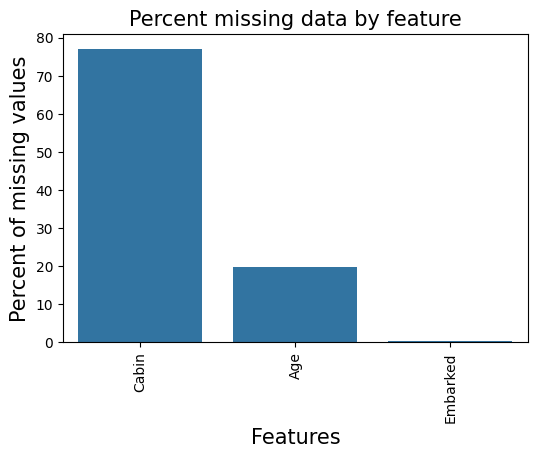

In [427]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na[train_na > 0].sort_values(ascending=False)  # Only keep columns with missing values

f, ax = plt.subplots(figsize=(6, 4))
plt.xticks(rotation=90)
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [428]:
print("Missing values in Train")
print(train.isnull().sum())

Missing values in Train
Survived          0
Pclass            0
Age             177
Ticket            0
Fare              0
Cabin           687
Embarked          2
FamilyCount       0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rare        0
Sex_male          0
dtype: int64


Text(0.5, 1.0, 'Percent missing data by feature')

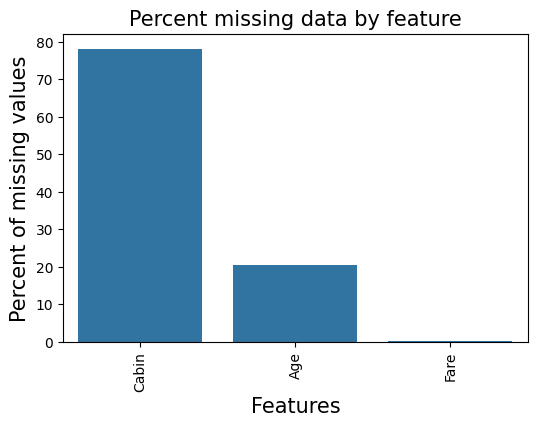

In [429]:
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na[test_na > 0].sort_values(ascending=False)  # Only keep columns with missing values

f, ax = plt.subplots(figsize=(6, 4))
plt.xticks(rotation=90)
sns.barplot(x=test_na.index, y=test_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [430]:
print("Missing values in Test")
print(test.isnull().sum())

Missing values in Test
Pclass            0
Age              86
Ticket            0
Fare              1
Cabin           327
Embarked          0
FamilyCount       0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rare        0
Sex_male          0
dtype: int64


### Drop columns that are unusefull
- `Cabin` has too many null values (687 out of 891 and 327 out of 418) so we will drop it.
- `Ticket` doesn't give us much insights.

In [431]:
columns_to_drop_train = ['Cabin', 'Ticket']
columns_to_drop_test = ['Cabin', 'Ticket']

train = train.drop(columns_to_drop_train, axis = 1)
test = test.drop(columns_to_drop_test, axis = 1)

There are 2 ways we can deal with empty values:
* dropping the rows/columns with empty values.
* imputation - filling the empty values.

Because our DataSet is already small we think it will be best to use the imputation technique for the `Age`, `Embarked` and `Fare`
columns because we dont want to loose valuabe data and make the Dataset even smaller.

### Handle missing values for 'Age'
We will present a heatmap of the features which have a correlation with the `Age`.

<Axes: >

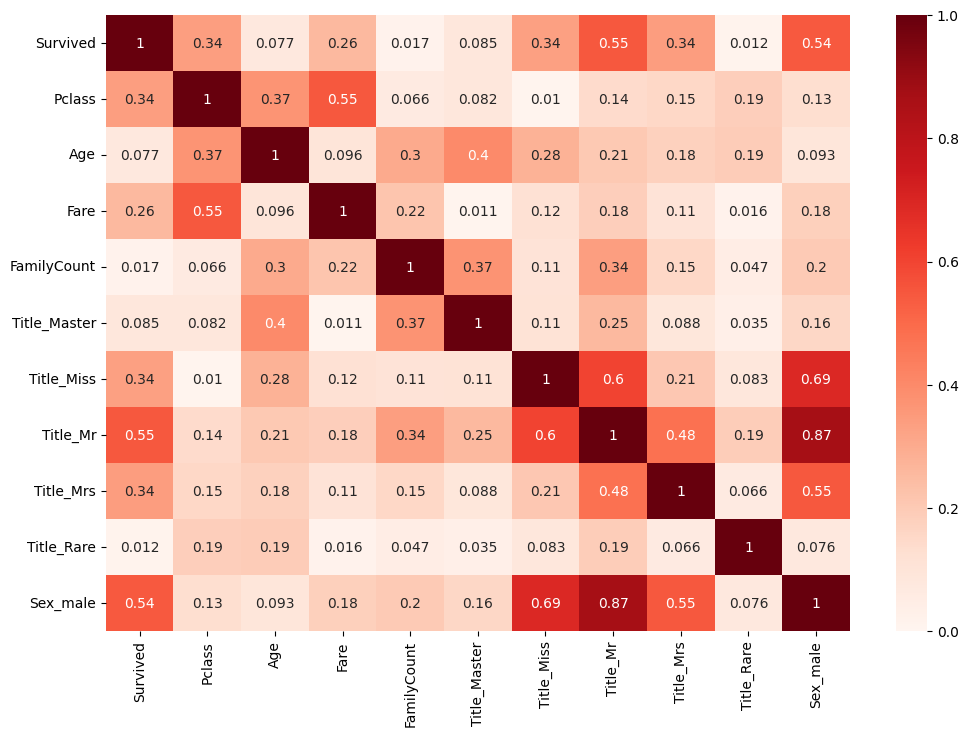

In [432]:
# Heatmap to visualize correlation between Age and other features
numeric_data = train.select_dtypes(include=['number'])
corr_mat = abs(numeric_data.corr())
plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1)

### Insights From Heatmap
* High correlation between `Age` and `Pclass`.
* High correlation between `Age` and `Titles`.
* we will also add the `Sex_male` that indicates the title's sex.

In [433]:
# create a 'Title' column based on the one-hot encoded title columns to get better results
data_sets = [train, test]

title_columns = ['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
title_mapping = {col: col.split('_')[1] for col in title_columns}

for df in data_sets:
    df['Title'] = df[title_columns].idxmax(axis=1)
    df['Title'] = df['Title'].map(title_mapping)

# grouping by 'Pclass', 'Sex_male', 'Title' to calculate median ages
for df in data_sets:
    median_ages = df.groupby(['Pclass', 'Sex_male', 'Title'])['Age'].transform('median')
    df['Age'] = df['Age'].fillna(median_ages)

train = train.drop('Title', axis=1)
test = test.drop('Title', axis=1)
data_sets = [train, test]
display(train)

,Survived,Pclass,Age,Fare,Embarked,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male
0,0,3,22.0,7.2500,S,2,0,0,1,0,0,1.0
1,1,1,38.0,71.2833,C,2,0,0,0,1,0,0.0
2,1,3,26.0,7.9250,S,1,0,1,0,0,0,0.0
3,1,1,35.0,53.1000,S,2,0,0,0,1,0,0.0
4,0,3,35.0,8.0500,S,1,0,0,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,S,1,0,0,0,0,1,1.0
887,1,1,19.0,30.0000,S,1,0,1,0,0,0,0.0
888,0,3,18.0,23.4500,S,4,0,1,0,0,0,0.0
889,1,1,26.0,30.0000,C,1,0,0,1,0,0,1.0


### Handle missing values for 'Fare' - Insights From Heatmap
From the heatmap we can see that there is high correlation between `Fare` and `Pclass`.  
We fill the missing `Fare` values by replacing them with the median `Fare` value for each `Pclass` in both the train and test datasets.

In [434]:
for df in data_sets:
    fare_by_pclass = df.groupby('Pclass')['Fare'].transform('median')
    df['Fare'] = df['Fare'].fillna(fare_by_pclass)

data_sets = [train, test]

### Handle missing values for 'Embarked'

**Distribution of 'Embarked' Values:**

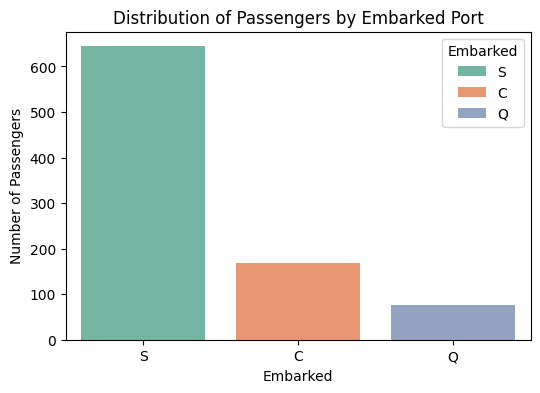

In [435]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Embarked', data=train, hue='Embarked', palette='Set2')
plt.title('Distribution of Passengers by Embarked Port')
plt.xlabel('Embarked')
plt.ylabel('Number of Passengers')
plt.show()

**Relation Between 'Embarked' and 'Pclass':**

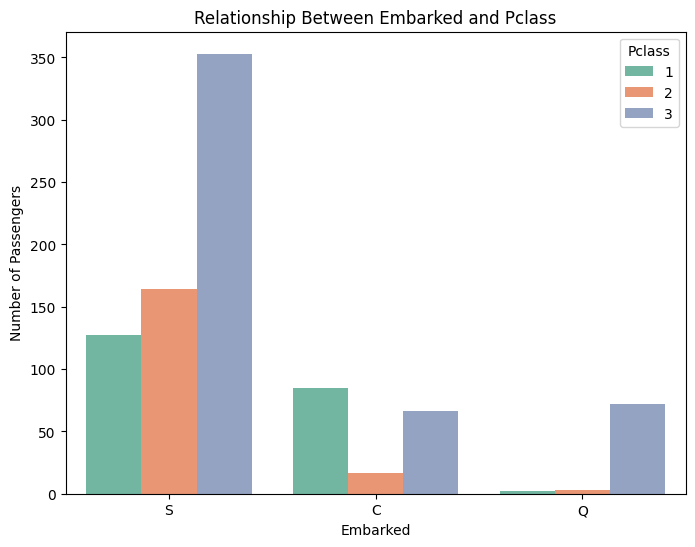

In [436]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Embarked', hue='Pclass', data=train, palette='Set2')
plt.title('Relationship Between Embarked and Pclass')
plt.xlabel('Embarked')
plt.ylabel('Number of Passengers')
plt.legend(title='Pclass', loc='upper right')
plt.show()

### **Insights from the plots**
* majority of passengers embarked at `S`.
* The majority of passengers who embarked at `S` were from `Pclass` 3, with the least from `Pclass` 1. For those who embarked at `C`, most were from `Pclass` 1. Similarly, the majority of passengers who embarked at `Q` were from `Pclass` 3.

From the insights we understand that `Pclass` and `Embarked` are related so we will fill the missing values using this column.

In [437]:
for df in data_sets:
    # Fill missing 'Embarked' values with the mode of 'Embarked' per 'Pclass'
    df['Embarked'] = df.groupby('Pclass')['Embarked'].transform(lambda x: x.mode()[0]).fillna(df['Embarked'])

In [438]:
print("Missing values in Train")
print(test.isnull().sum())

Missing values in Train
Pclass          0
Age             0
Fare            0
Embarked        0
FamilyCount     0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
Sex_male        0
dtype: int64


In [439]:
print("Missing values in Test")
print(test.isnull().sum())

Missing values in Test
Pclass          0
Age             0
Fare            0
Embarked        0
FamilyCount     0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
Sex_male        0
dtype: int64


## Encoding the data  - `Embarked`

---

### One-Hot Encode Categorical Features
Since `Embarked` is a categorical feature with three categories (S, Q, and C), we can encode it using One-Hot Encoding.  
We will do this with the get_dummies() function in Panda.

In [440]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Age           891 non-null    float64
 3   Fare          891 non-null    float64
 4   Embarked      891 non-null    object 
 5   FamilyCount   891 non-null    int64  
 6   Title_Master  891 non-null    int64  
 7   Title_Miss    891 non-null    int64  
 8   Title_Mr      891 non-null    int64  
 9   Title_Mrs     891 non-null    int64  
 10  Title_Rare    891 non-null    int64  
 11  Sex_male      891 non-null    float64
dtypes: float64(3), int64(8), object(1)
memory usage: 83.7+ KB


In [441]:
# One-hot encode the 'Title' feature
train_title_dummies = pd.get_dummies(train['Embarked'], prefix='Embarked', dtype=int)
test_title_dummies = pd.get_dummies(test['Embarked'], prefix='Embarked', dtype=int)

# Align the columns for train and test datasets
train_title_dummies, test_title_dummies = train_title_dummies.align(test_title_dummies, fill_value=0, axis=1)

# Add the encoded columns to the original DataFrame
train = pd.concat([train, train_title_dummies], axis=1).drop(columns=['Embarked'])
test = pd.concat([test, test_title_dummies], axis=1).drop(columns=['Embarked'])

In [442]:
# Display the updated train dataframe
display(train)

,Survived,Pclass,Age,Fare,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male,Embarked_C,Embarked_S
0,0,3,22.0,7.2500,2,0,0,1,0,0,1.0,0,1
1,1,1,38.0,71.2833,2,0,0,0,1,0,0.0,0,1
2,1,3,26.0,7.9250,1,0,1,0,0,0,0.0,0,1
3,1,1,35.0,53.1000,2,0,0,0,1,0,0.0,0,1
4,0,3,35.0,8.0500,1,0,0,1,0,0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,1,0,0,0,0,1,1.0,0,1
887,1,1,19.0,30.0000,1,0,1,0,0,0,0.0,0,1
888,0,3,18.0,23.4500,4,0,1,0,0,0,0.0,0,1
889,1,1,26.0,30.0000,1,0,0,1,0,0,1.0,0,1


## Dealing with outliers  
Outliers are data points that significantly differ from the rest of the data. They can be unusually high or low compared to the other observations in the dataset.  

**Improving model performance** - Outliers can distort the model’s learning process. They can skew the results and lead to inaccurate predictions. By handling outliers, we can help the model learn more meaningful patterns from the data.

---

We use scatter plots to visualize the relationship between the three feature- `Age`, `Fare` and `FamilyCount`, and the target variable, `Survived`.  
The rest of the features have binary values so we didn't choose to focuse on them.  

Outliers are often represented as data points that are far away from the general trend or cluster of data points.

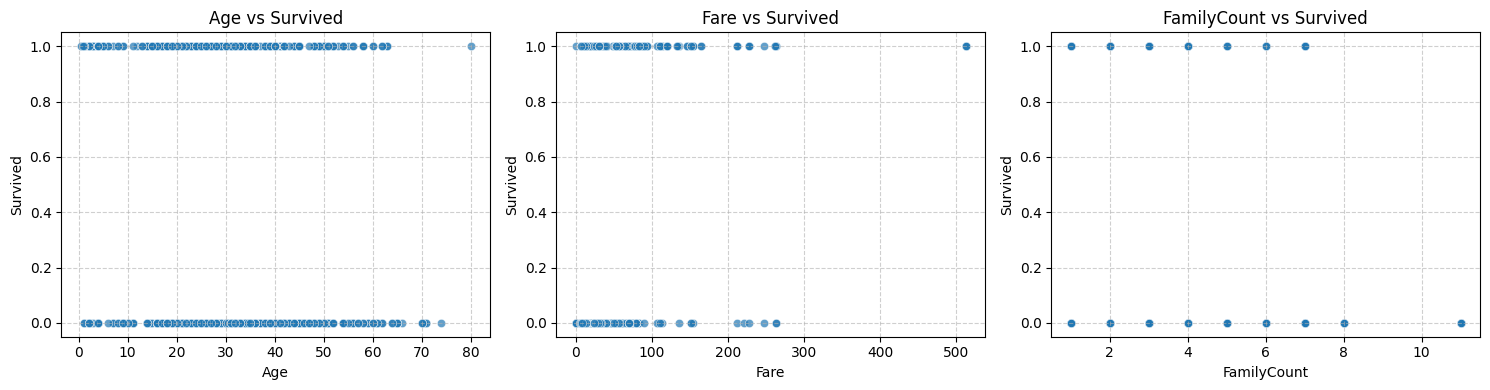

In [443]:
def scatter_plot_features_vs_survived(df, features=['Age', 'Fare', 'FamilyCount'], target='Survived', cols=3):
    rows = (len(features) + cols - 1) // cols  # Calculate required rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Flatten to simplify indexing
    
    for i, feature in enumerate(features):
        # Scatter plot for the feature vs target
        sns.scatterplot(data=df, x=feature, y=target, alpha=0.7, ax=axes[i])
        axes[i].set_title(f'{feature} vs {target}', fontsize=12)
        axes[i].set_xlabel(feature, fontsize=10)
        axes[i].set_ylabel(target, fontsize=10)
        axes[i].grid(True, linestyle='--', alpha=0.6)
        
        # Highlight potential outliers (values outside 1.5 * IQR)
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()  # Adjust layout for readability
    plt.show()

# Call the function for specific features
scatter_plot_features_vs_survived(train, features=['Age', 'Fare', 'FamilyCount'], cols=3)


In [444]:
train = train.drop(train[train['Age'] > 70].index)
train = train.drop(train[train['Fare'] >= 300].index)
train = train.drop(train[train['FamilyCount'] >= 9].index)

## Cross-Validation
We used K-fold cross-validation to evaluate the model's performance. The dataset is split into 'k' folds, where the model is trained on 'k-1' folds and tested on the remaining fold. This process is repeated 'k' times, and the performance metrics (accuracy, precision, recall, F1 score, and loss) are averaged to get a robust estimate of the model's performance. We chosed k = 5.

---

We will take the target out of the original DataFrame.

In [446]:
# divide the data to features and target
t = train['Survived'].copy()
X = train.drop(['Survived'], axis=1)
print('t')
display(t)
print()
print('X')
display(X)

t


0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 876, dtype: int64


X


,Pclass,Age,Fare,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male,Embarked_C,Embarked_S
0,3,22.0,7.2500,2,0,0,1,0,0,1.0,0,1
1,1,38.0,71.2833,2,0,0,0,1,0,0.0,0,1
2,3,26.0,7.9250,1,0,1,0,0,0,0.0,0,1
3,1,35.0,53.1000,2,0,0,0,1,0,0.0,0,1
4,3,35.0,8.0500,1,0,0,1,0,0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,13.0000,1,0,0,0,0,1,1.0,0,1
887,1,19.0,30.0000,1,0,1,0,0,0,0.0,0,1
888,3,18.0,23.4500,4,0,1,0,0,0,0.0,0,1
889,1,26.0,30.0000,1,0,0,1,0,0,1.0,0,1


**KFold cross-validation to evaluate the model’s performance:**  
- **Data Splitting:** The data is split into k folds for training and testing.
- **Training and Prediction:** The model is trained on each fold and tested on the remaining fold.
- **Metrics Calculation:** Accuracy, precision, recall, F1 score, and log loss are calculated for both training and validation sets.
- **Confusion Matrix:** A confusion matrix is displayed for each fold.
- **Analysis:** The difference between training and validation metrics is shown for each fold.
- **Final Averages:** The average metrics across all folds are printed.

Training for fold 1
X_train shape: (700, 12), X_val shape: (176, 12)


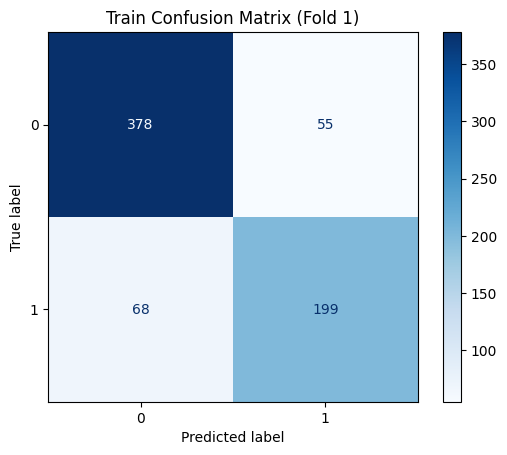

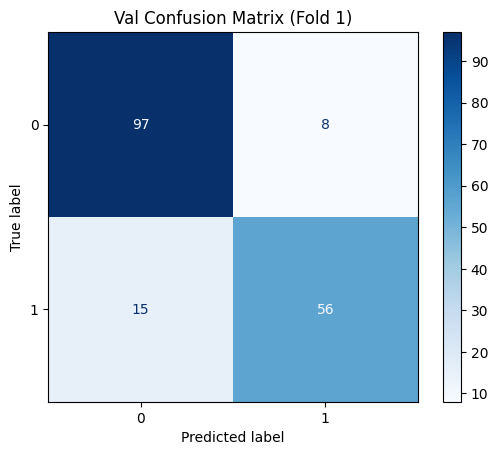


Analysis for Fold 1:
Accuracy - Train: 0.8243, Validation: 0.8693, Difference: 0.0450
Precision - Train: 0.7835, Validation: 0.8750, Difference: 0.0915
Recall - Train: 0.7453, Validation: 0.7887, Difference: 0.0434
F1_score - Train: 0.7639, Validation: 0.8296, Difference: 0.0657
Loss - Train: 0.4177, Validation: 0.4025, Difference: 0.0151
------------------------------
Training for fold 2
X_train shape: (701, 12), X_val shape: (175, 12)


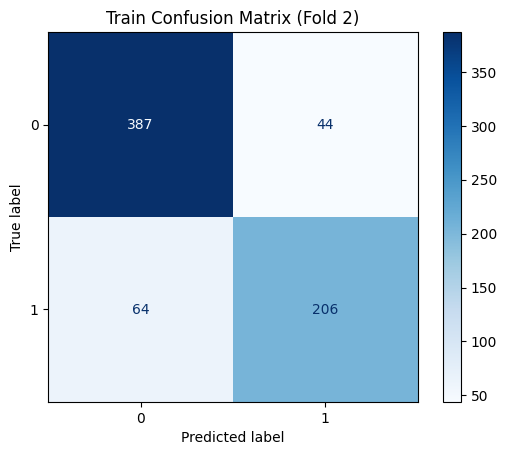

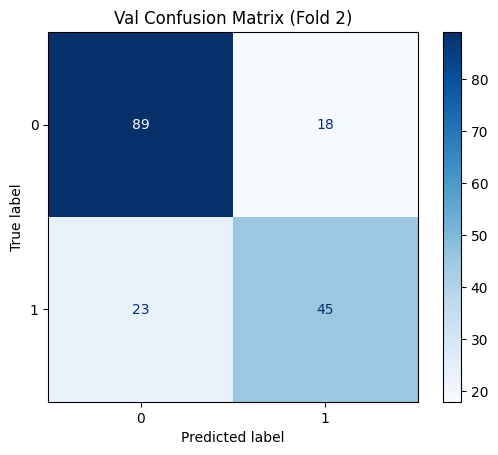


Analysis for Fold 2:
Accuracy - Train: 0.8459, Validation: 0.7657, Difference: 0.0802
Precision - Train: 0.8240, Validation: 0.7143, Difference: 0.1097
Recall - Train: 0.7630, Validation: 0.6618, Difference: 0.1012
F1_score - Train: 0.7923, Validation: 0.6870, Difference: 0.1053
Loss - Train: 0.3896, Validation: 0.5064, Difference: 0.1168
------------------------------
Training for fold 3
X_train shape: (701, 12), X_val shape: (175, 12)


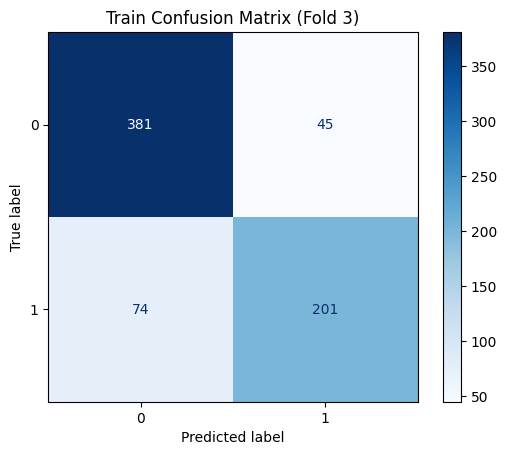

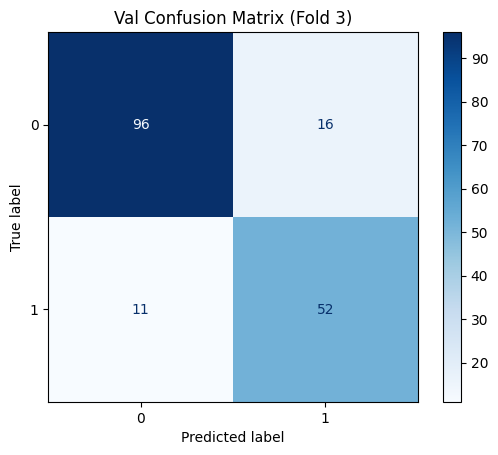


Analysis for Fold 3:
Accuracy - Train: 0.8302, Validation: 0.8457, Difference: 0.0155
Precision - Train: 0.8171, Validation: 0.7647, Difference: 0.0524
Recall - Train: 0.7309, Validation: 0.8254, Difference: 0.0945
F1_score - Train: 0.7716, Validation: 0.7939, Difference: 0.0223
Loss - Train: 0.4233, Validation: 0.3769, Difference: 0.0463
------------------------------
Training for fold 4
X_train shape: (701, 12), X_val shape: (175, 12)


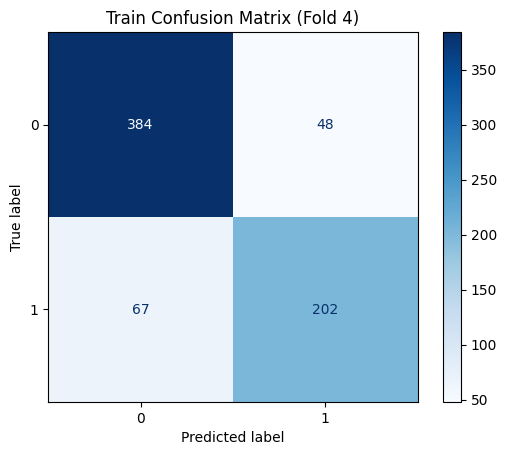

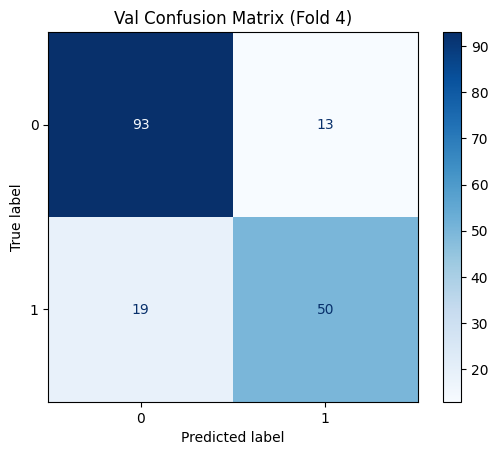


Analysis for Fold 4:
Accuracy - Train: 0.8359, Validation: 0.8171, Difference: 0.0188
Precision - Train: 0.8080, Validation: 0.7937, Difference: 0.0143
Recall - Train: 0.7509, Validation: 0.7246, Difference: 0.0263
F1_score - Train: 0.7784, Validation: 0.7576, Difference: 0.0208
Loss - Train: 0.4140, Validation: 0.4127, Difference: 0.0013
------------------------------
Training for fold 5
X_train shape: (701, 12), X_val shape: (175, 12)


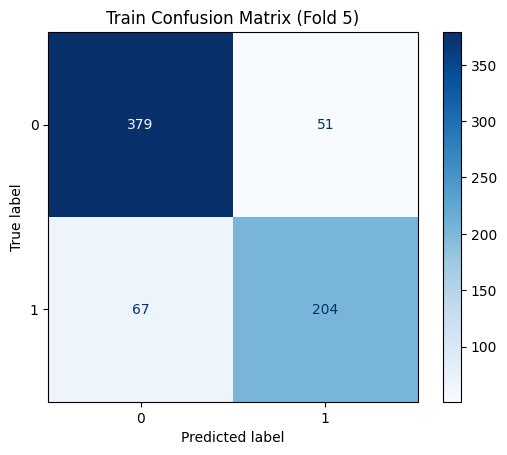

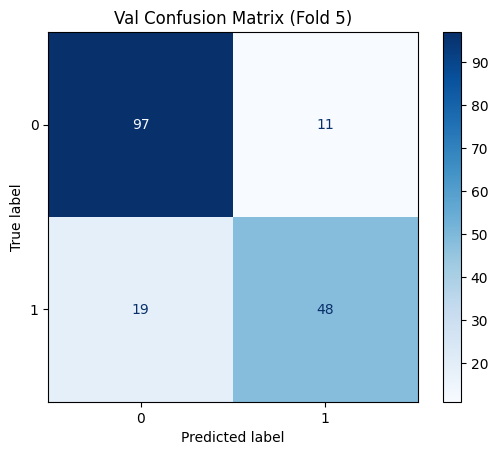


Analysis for Fold 5:
Accuracy - Train: 0.8317, Validation: 0.8286, Difference: 0.0031
Precision - Train: 0.8000, Validation: 0.8136, Difference: 0.0136
Recall - Train: 0.7528, Validation: 0.7164, Difference: 0.0363
F1_score - Train: 0.7757, Validation: 0.7619, Difference: 0.0138
Loss - Train: 0.4158, Validation: 0.4063, Difference: 0.0095
------------------------------

Train Set Metrics (Averages):
Accuracy: 0.8336
Precision: 0.8065
Recall: 0.7486
F1_score: 0.7764
Loss: 0.4121

Val Set Metrics (Averages):
Accuracy: 0.8253
Precision: 0.7922
Recall: 0.7434
F1_score: 0.7660
Loss: 0.4210


In [447]:
def evaluate_kfold(X, t, model, k=5):
    # Ensure indices are continuous if using Pandas
    X = X.reset_index(drop=True)
    t = t.reset_index(drop=True)

    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    metrics = {
        "train": {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "loss": []},
        "val": {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "loss": []}
    }

    for fold, (train_ids, val_ids) in enumerate(kf.split(X)):
        print(f"Training for fold {fold + 1}")  # Debug
        
        # Split the data
        X_train, X_val = X.loc[train_ids], X.loc[val_ids]
        y_train, y_val = t.loc[train_ids], t.loc[val_ids]

        print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")  # Debug

        # Train the model
        model.fit(X_train, y_train)

        # Predict on training and validation sets
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        # Store metrics for both train and validation sets
        for split, y_true, y_pred, X_data in [
            ("train", y_train, y_pred_train, X_train),
            ("val", y_val, y_pred_val, X_val)
        ]:
            metrics[split]["accuracy"].append(accuracy_score(y_true, y_pred))
            metrics[split]["precision"].append(precision_score(y_true, y_pred, average="binary"))
            metrics[split]["recall"].append(recall_score(y_true, y_pred, average="binary"))
            metrics[split]["f1_score"].append(f1_score(y_true, y_pred, average="binary"))
            metrics[split]["loss"].append(log_loss(y_true, model.predict_proba(X_data)))

            # Confusion Matrix
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap="Blues")
            plt.title(f"{split.capitalize()} Confusion Matrix (Fold {fold + 1})")
            plt.show()

        # Fold-wise Analysis
        print(f"\nAnalysis for Fold {fold + 1}:")
        for metric in ["accuracy", "precision", "recall", "f1_score", "loss"]:
            train_metric = metrics["train"][metric][-1]
            val_metric = metrics["val"][metric][-1]
            difference = abs(train_metric - val_metric)
            print(f"{metric.capitalize()} - Train: {train_metric:.4f}, Validation: {val_metric:.4f}, Difference: {difference:.4f}")

        print("-" * 30)

    # Compute average metrics across all folds
    for split in ["train", "val"]:
        print(f"\n{split.capitalize()} Set Metrics (Averages):")
        for metric in metrics[split]:
            avg_metric = sum(metrics[split][metric]) / len(metrics[split][metric])
            print(f"{metric.capitalize()}: {avg_metric:.4f}")

# Example Usage
# Assuming X and t are Pandas DataFrame and Series respectively
model = LogisticRegression(max_iter=1000)
evaluate_kfold(X, t, model)


This code plots accuracy and log loss for both training and validation sets across the 5 folds of KFold cross-validation.

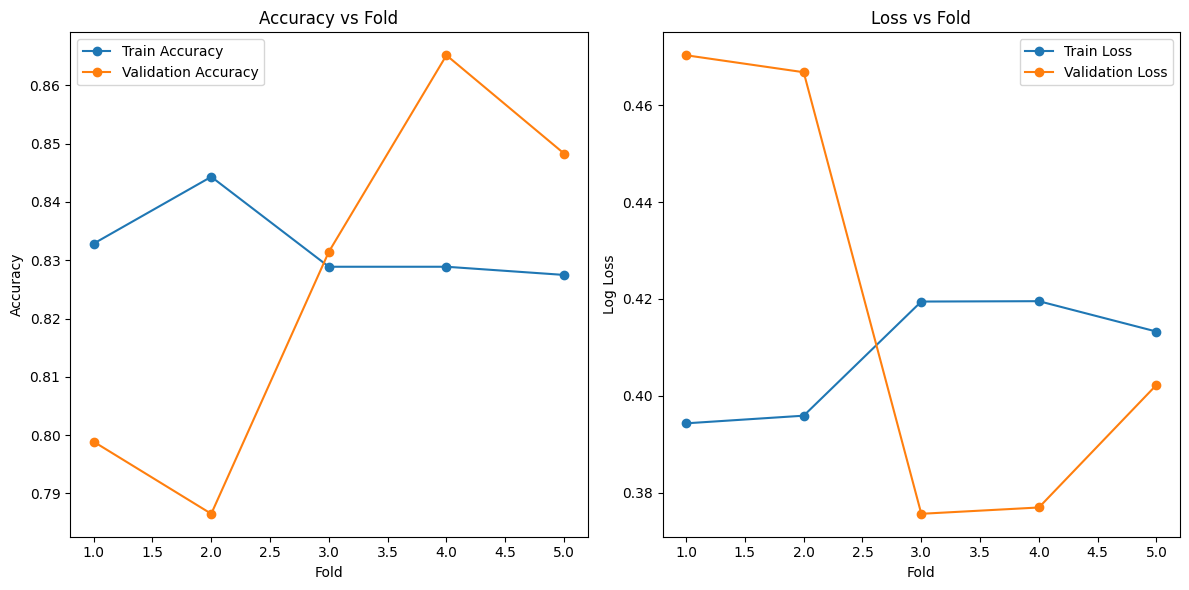

In [448]:
# Plot Loss and Accuracy
# Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), accuracy_train_list, label='Train Accuracy', marker='o')
plt.plot(range(1, 6), accuracy_val_list, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), loss_train_list, label='Train Loss', marker='o')
plt.plot(range(1, 6), loss_val_list, label='Validation Loss', marker='o')
plt.title('Loss vs Fold')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Exporting model results
Now we run the model on the test and get the results into a csv file.  

---

In [452]:
# Assuming `test` is your test DataFrame and the model has already been trained
features = ['Pclass', 'Age', 'Fare', 'FamilyCount', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Sex_male', 'Embarked_C', 'Embarked_S']

# Make predictions on the test set
y_pred_test = model.predict(test[features])  # Use the same features used for training

# Create a DataFrame with PassengerId and Survived columns
results = pd.DataFrame({
    'PassengerId': test_ID,
    'Survived': y_pred_test
})

# Save the results to a CSV file
results.to_csv('submission.csv', index=False)

print("Results saved to 'submission.csv'")


Results saved to 'submission.csv'


## **Submission in Kaggle**  
We will now apply this trained model to make predictions on the test set and submit the results in the required format.  

---

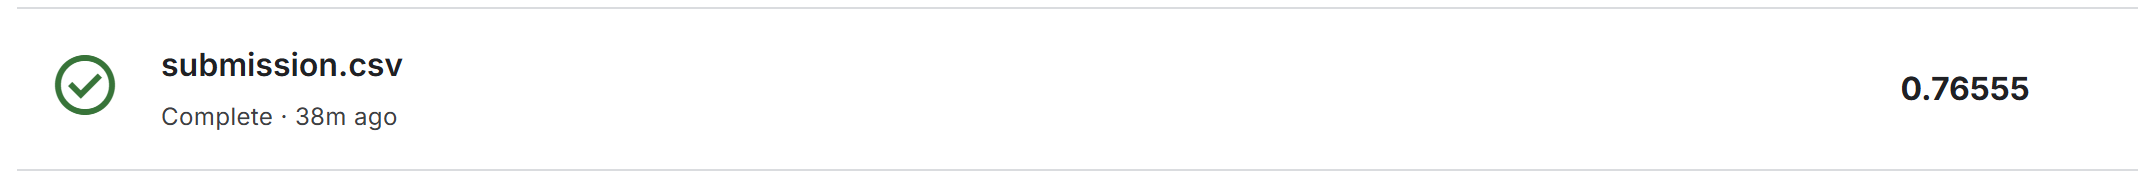

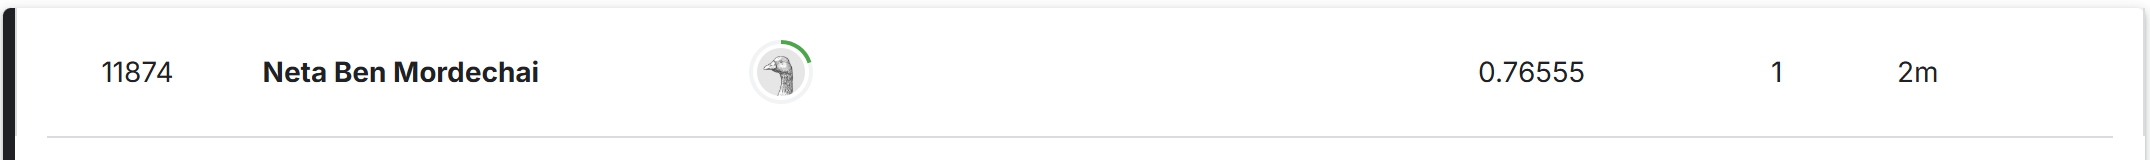

## **Summary**   
---

In this project, we analyzed the Titanic dataset to predict passenger survival using logistic regression. The process included data cleaning (handling missing values and outliers), feature engineering (such as encoding categorical variables), and model training. We used KFold cross-validation to evaluate the model performance, testing metrics like accuracy, precision, recall, F1 score, and log loss. The logistic regression model was then evaluated on test data, and the results were saved into a CSV file. Visualizations were created to understand the impact of features on survival.  

**References:**  
- Lab notebooks
- Chat GPT
- Kaggle competitor notebook: https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling#1.-Introduction